In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn pydantic firebase-admin scikit-learn

import nest_asyncio
from pyngrok import ngrok
import threading
import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
import requests
import time
import pickle
import firebase_admin
from firebase_admin import credentials, firestore
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pickle


X_class, y_class = make_classification(
    n_samples=100,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    random_state=42
)


X_reg, y_reg = make_regression(n_samples=100, n_features=5, random_state=42)


clf = RandomForestClassifier()
clf.fit(X_class, y_class)


reg = RandomForestRegressor()
reg.fit(X_reg, y_reg)


with open('classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('regressor.pkl', 'wb') as f:
    pickle.dump(reg, f)

print("Models saved successfully.")


Models saved successfully.


In [ ]:

!pip install pandas requests

import pandas as pd
import requests
from datetime import datetime, timedelta


def fetch_usgs(start, end, min_mag=2.5):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "starttime": start,
        "endtime": end,
        "minmagnitude": min_mag,
        "limit": 20000
    }
    r = requests.get(url, params=params)
    data = r.json().get("features", [])
    records = []
    for feat in data:
        p = feat["properties"]
        lon, lat, depth = feat["geometry"]["coordinates"]
        records.append({
            "time": pd.to_datetime(p["time"], unit="ms"),
            "latitude": lat,
            "longitude": lon,
            "depth": depth,
            "mag": p["mag"],
            "place": p["place"]
        })
    return pd.DataFrame(records)


all_df = []
start = datetime(2024, 1, 1)
end = datetime(2025, 4, 23)
while start > datetime(2015, 1, 1) and sum(len(df) for df in all_df) < 3000:
    chunk = fetch_usgs(start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))
    all_df.append(chunk)
    end = start - timedelta(days=1)
    start = end - timedelta(days=90)

df = pd.concat(all_df, ignore_index=True).drop_duplicates().reset_index(drop=True)
print("Total rows fetched:", len(df))


df = df[df.mag.notnull() & df.depth.notnull() & df.latitude.notnull() & df.longitude.notnull()]
if len(df) < 3000:
    raise RuntimeError(f"Only {len(df)} rows; adjust date ranges or min_magnitude")


df["year"]  = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"]   = df["time"].dt.day
df["hour"]  = df["time"].dt.hour

def classify_severity(m):
    if m < 4.0:   return "mild"
    if m < 6.0:   return "moderate"
    return "severe"

df["severity"] = df["mag"].apply(classify_severity)


out_cols = [
    "time", "year", "month", "day", "hour",
    "latitude", "longitude", "depth",
    "mag", "severity", "place"
]
df[out_cols].to_csv("earthquake_3000_plus.csv", index=False)
print("Saved earthquake_3000_plus.csv with columns:", out_cols)


Total rows fetched: 19999
Saved earthquake_3000_plus.csv with columns: ['time', 'year', 'month', 'day', 'hour', 'latitude', 'longitude', 'depth', 'mag', 'severity', 'place']


In [ ]:
from google.colab import files


files.download('earthquake_3000_plus.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd


df = pd.read_csv('earthquake_3000_plus.csv')


df.head()


,time,year,month,day,hour,latitude,longitude,depth,mag,severity,place
0,2025-04-22 23:39:42.277,2025,4,22,23,44.4943,151.8614,10.000,4.4,moderate,east of the Kuril Islands
1,2025-04-22 22:55:06.335,2025,4,22,22,51.8485,-171.6897,40.304,3.7,mild,"176 km ESE of Atka, Alaska"
2,2025-04-22 22:21:52.901,2025,4,22,22,41.0968,142.9669,51.442,4.6,moderate,"114 km S of Honchō, Japan"
3,2025-04-22 22:10:20.618,2025,4,22,22,11.9495,125.3842,41.491,4.6,moderate,"6 km NW of Taft, Philippines"
4,2025-04-22 21:42:15.948,2025,4,22,21,-6.2112,151.4026,10.000,4.9,moderate,"157 km ESE of Kimbe, Papua New Guinea"


In [ ]:
import os, pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Create models folder
os.makedirs('models', exist_ok=True)

# 2. Features and targets
X = df[['latitude', 'longitude', 'depth']].values
y_clf = df['severity'].values
y_reg = df['mag'].values.astype(float)

# 3. Encode severity labels
le = LabelEncoder()
y_clf_enc = le.fit_transform(y_clf)

# 4. Train/test split
X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
    X, y_clf_enc, y_reg, test_size=0.2, random_state=42)

# 5. Train models
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_clf_train)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_reg_train)

# 6. Save classifier + label encoder together
with open('models/classifier.pkl', 'wb') as f:
    pickle.dump((clf, le), f)

# 7. Save regressor
with open('models/regressor.pkl', 'wb') as f:
    pickle.dump(reg, f)

print(" Models saved in /models")
# Optionally check performance
print("Classification accuracy:", clf.score(X_test, y_clf_test))
from sklearn.metrics import mean_squared_error
print("Regression RMSE:", mean_squared_error(y_reg_test, reg.predict(X_test)))


 Models saved in /models
Classification accuracy: 0.96425
Regression RMSE: 0.18245996355422722


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_reg_test, reg.predict(X_test))
rmse = np.sqrt(mse)
print("Regression RMSE:", rmse)


Regression RMSE: 0.42715332558020336


In [ ]:
import os, pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


os.makedirs('models', exist_ok=True)


X = df[['latitude', 'longitude', 'depth']].values
y_clf = df['severity'].values
y_reg = df['mag'].values.astype(float)


le = LabelEncoder()
y_clf_enc = le.fit_transform(y_clf)


X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
    X, y_clf_enc, y_reg, test_size=0.2, random_state=42)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_clf_train)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_reg_train)


with open('models/classifier.pkl', 'wb') as f:
    pickle.dump((clf, le), f)


with open('models/regressor.pkl', 'wb') as f:
    pickle.dump(reg, f)

print(" Models saved in /models")

print("Classification accuracy:", clf.score(X_test, y_clf_test))
from sklearn.metrics import mean_squared_error
print("Regression RMSE:", mean_squared_error(y_reg_test, reg.predict(X_test)))


 Models saved in /models
Classification accuracy: 0.96425
Regression RMSE: 0.18245996355422722


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_reg_test, reg.predict(X_test))
rmse = np.sqrt(mse)
print("Regression RMSE:", rmse)


Regression RMSE: 0.42715332558020336


In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore


cred = credentials.Certificate("earth.json")


if not firebase_admin._apps:
    firebase_admin.initialize_app(cred)


db = firestore.client()


In [ ]:

example_data = {
    'latitude': 34.05,
    'longitude': -118.24,
    'depth': 10,
    'severity_prediction': 'moderate',
    'magnitude_prediction': 5.7
}


db.collection('earthquake_predictions').add(example_data)


(DatetimeWithNanoseconds(2025, 4, 25, 16, 16, 51, 848238, tzinfo=datetime.timezone.utc),
 <google.cloud.firestore_v1.document.DocumentReference at 0x7f4b797c2850>)

In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore


if not firebase_admin._apps:
    cred = credentials.Certificate("earth.json")
    firebase_admin.initialize_app(cred)


db = firestore.client()


In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn tensorflow keras opencv-python firebase-admin


In [ ]:
%%writefile requirements.txt
numpy
pandas
scikit-learn
matplotlib
seaborn
tensorflow
keras
opencv-python
firebase-admin


Writing requirements.txt


In [ ]:
!pip install -r requirements.txt


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving earthquake_3000_plus (2).csv to earthquake_3000_plus (2).csv


In [ ]:
import pandas as pd

df = pd.read_csv("earthquake_3000_plus (2).csv")
df.head()


,time,year,month,day,hour,latitude,longitude,depth,mag,severity,place
0,2025-04-22 22:55:04.145,2025,4,22,22,51.8020,-171.6241,25.500,3.5,mild,"182 km ESE of Atka, Alaska"
1,2025-04-22 20:37:35.413,2025,4,22,20,-20.5650,-173.5086,10.000,5.1,moderate,"121 km SE of Pangai, Tonga"
2,2025-04-22 19:10:41.906,2025,4,22,19,-7.4159,128.9263,143.201,4.4,moderate,"245 km ENE of Lospalos, Timor Leste"
3,2025-04-22 18:44:15.110,2025,4,22,18,18.8020,-64.5565,50.630,3.2,mild,"57 km NNE of Cruz Bay, U.S. Virgin Islands"
4,2025-04-22 17:56:12.904,2025,4,22,17,23.8555,69.8424,10.000,3.9,mild,"68 km NNE of Bhuj, India"


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("earthquake_3000_plus (2).csv")


le = LabelEncoder()
df['place_encoded'] = le.fit_transform(df['place'])


features = ['latitude', 'longitude', 'depth', 'year', 'month', 'day', 'hour', 'place_encoded']


df['severity'] = le.fit_transform(df['severity'])
X_clf = df[features]
y_clf = df['severity']


X_reg = df[features]
y_reg = df['mag']


X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import train_test_split


X = df.drop(['mag'], axis=1)
y_reg = df['mag']
y_clf = (df['mag'] >= 5).astype(int)

X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)


In [ ]:

!pip install pandas requests


import pandas as pd
import requests
from datetime import datetime, timedelta


orig = pd.read_csv("earthquake_3000_plus (2).csv", parse_dates=["time"])
print("Original rows:", len(orig))
print(orig.mag.describe())


def fetch_usgs_mag6(start, end):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "starttime": start,
        "endtime": end,
        "minmagnitude": 6.0,
        "limit": 20000
    }
    r = requests.get(url, params=params)
    data = r.json().get("features", [])
    recs = []
    for feat in data:
        p = feat["properties"]
        lon, lat, depth = feat["geometry"]["coordinates"]
        recs.append({
            "time": pd.to_datetime(p["time"], unit="ms"),
            "latitude": lat,
            "longitude": lon,
            "depth": depth,
            "mag": p["mag"],
            "place": p["place"]
        })
    return pd.DataFrame(recs)


frames = [orig]
end = datetime.utcnow()
start = end - timedelta(days=5*365)
while start < end:
    chunk_end = start + timedelta(days=180)
    df6 = fetch_usgs_mag6(start.strftime("%Y-%m-%d"), chunk_end.strftime("%Y-%m-%d"))
    frames.append(df6)
    start = chunk_end + timedelta(days=1)


full = pd.concat(frames, ignore_index=True)
full.drop_duplicates(subset=["time","latitude","longitude"], inplace=True)
full.dropna(subset=["mag","depth"], inplace=True)
print("Merged rows:", len(full))
print("Magnitudes now range:", full.mag.min(), "to", full.mag.max())


full["year"]  = full.time.dt.year
full["month"] = full.time.dt.month
full["day"]   = full.time.dt.day
full["hour"]  = full.time.dt.hour

def label_severity(mag, depth):
    if mag >= 6.0 and depth <= 100:
        return "severe"
    elif 4.5 <= mag < 6.0 and depth <= 300:
        return "moderate"
    else:
        return "mild"


full["severity"] = full.apply(lambda row: label_severity(row["mag"], row["depth"]), axis=1)




out_cols = ["time","year","month","day","hour","latitude","longitude","depth","mag","severity","place"]
full[out_cols].to_csv("earthquake_with_severity.csv", index=False)
print("Saved final dataset with all three classes:", full.severity.value_counts())


Original rows: 19999
count    19999.000000
mean         3.825300
std          0.851458
min          2.500000
25%          2.940000
50%          4.100000
75%          4.500000
max          7.700000
Name: mag, dtype: float64
Merged rows: 20564
Magnitudes now range: 2.5 to 8.2
Saved final dataset with all three classes: severity
mild        15277
moderate     4785
severe        502
Name: count, dtype: int64


In [ ]:
print(full["severity"].value_counts())


severity
mild        15277
moderate     4785
severe        502
Name: count, dtype: int64


In [ ]:
import pandas as pd


df = pd.read_csv("earthquake_with_severity.csv", parse_dates=["time"])
print("Rows:", len(df))
df.head()


Rows: 20564


,time,year,month,day,hour,latitude,longitude,depth,mag,severity,place
0,2025-04-22 22:55:04.145,2025,4,22,22,51.8020,-171.6241,25.500,3.5,mild,"182 km ESE of Atka, Alaska"
1,2025-04-22 20:37:35.413,2025,4,22,20,-20.5650,-173.5086,10.000,5.1,moderate,"121 km SE of Pangai, Tonga"
2,2025-04-22 19:10:41.906,2025,4,22,19,-7.4159,128.9263,143.201,4.4,mild,"245 km ENE of Lospalos, Timor Leste"
3,2025-04-22 18:44:15.110,2025,4,22,18,18.8020,-64.5565,50.630,3.2,mild,"57 km NNE of Cruz Bay, U.S. Virgin Islands"
4,2025-04-22 17:56:12.904,2025,4,22,17,23.8555,69.8424,10.000,3.9,mild,"68 km NNE of Bhuj, India"


In [ ]:

df['hour']   = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['second'] = df['time'].dt.second


X = df.drop(columns=['time','place','mag','severity'])


y_reg = df['mag']


severity_map = {'mild':0, 'moderate':1, 'severe':2}
y_clf = df['severity'].map(severity_map)


print("Feature shape:", X.shape)
print("Regression target shape:", y_reg.shape)
print("Classification distribution:\n", df['severity'].value_counts())


Feature shape: (20564, 9)
Regression target shape: (20564,)
Classification distribution:
 severity
mild        15277
moderate     4785
severe        502
Name: count, dtype: int64


 Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      3764
           1       0.87      0.34      0.49       349

    accuracy                           0.94      4113
   macro avg       0.91      0.67      0.73      4113
weighted avg       0.94      0.94      0.93      4113



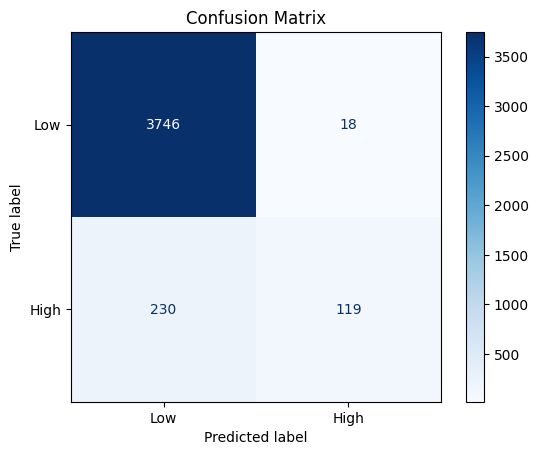

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


features = ['year', 'month', 'day', 'hour', 'latitude', 'longitude', 'depth']


df['high_impact'] = (df['mag'] >= 5).astype(int)

X = df[features]
y_clf = df['high_impact']


X_train, X_test, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)


clf_model = RandomForestClassifier()
clf_model.fit(X_train, y_clf_train)


clf_preds = clf_model.predict(X_test)


print(" Classification Report:\n", classification_report(y_clf_test, clf_preds))


cm = confusion_matrix(y_clf_test, clf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


🔹 Regression MAE:  0.304
🔹 Regression RMSE: 0.432


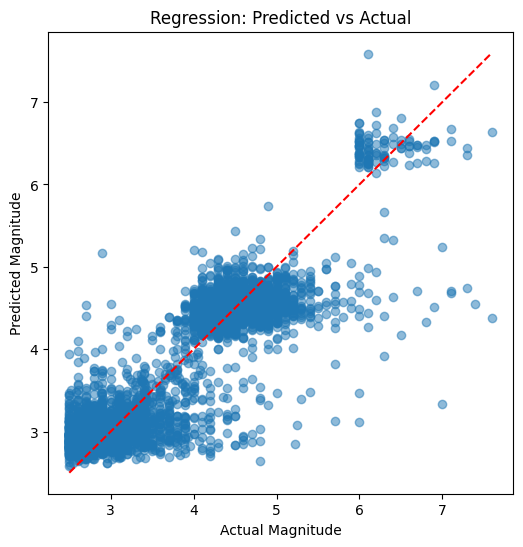

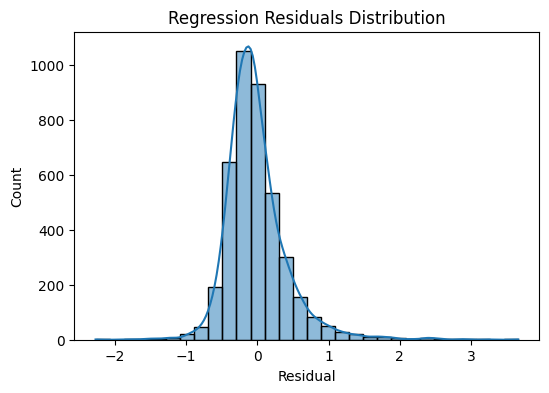

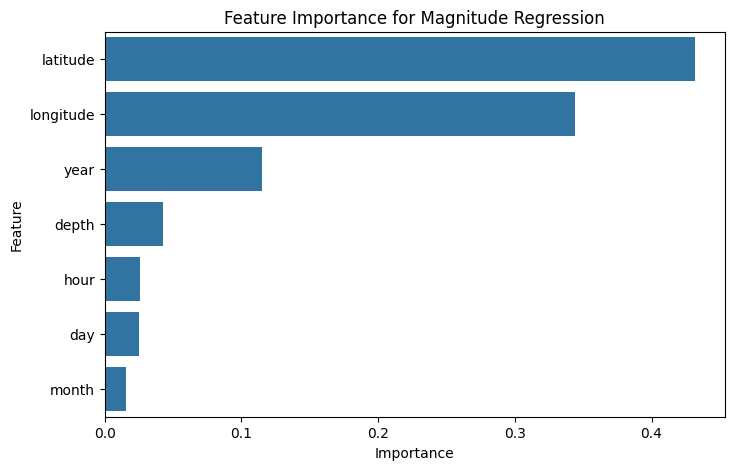

🔹 Classification Accuracy: 0.939

Classification Report:
               precision    recall  f1-score   support

         Low       0.94      1.00      0.97      3764
        High       0.87      0.33      0.48       349

    accuracy                           0.94      4113
   macro avg       0.91      0.66      0.72      4113
weighted avg       0.94      0.94      0.93      4113



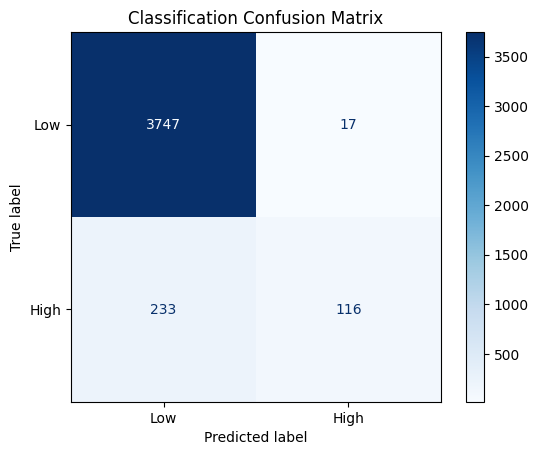

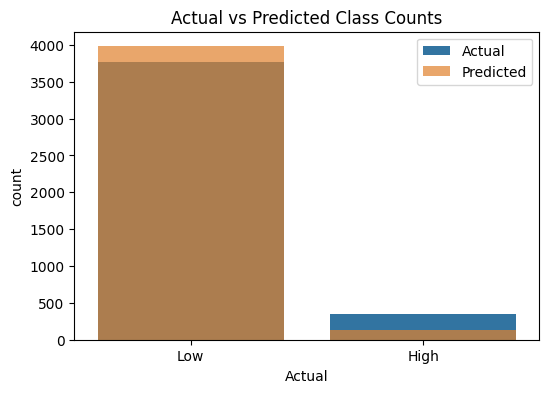

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)


features = ['year','month','day','hour','latitude','longitude','depth']
X = df[features]
y_reg = df['mag']
y_clf = (df['mag'] >= 5).astype(int)


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)


reg = RandomForestRegressor(random_state=42).fit(X_train_reg, y_train_reg)
clf = RandomForestClassifier(random_state=42).fit(X_train_clf, y_train_clf)


y_pred_reg = reg.predict(X_test_reg)
mae  = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"🔹 Regression MAE:  {mae:.3f}")
print(f"🔹 Regression RMSE: {rmse:.3f}")


plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
lims = [min(y_test_reg.min(), y_pred_reg.min()), max(y_test_reg.max(), y_pred_reg.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Magnitude"); plt.ylabel("Predicted Magnitude")
plt.title("Regression: Predicted vs Actual")
plt.show()


residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Regression Residuals Distribution")
plt.xlabel("Residual")
plt.show()


importances = reg.feature_importances_
feat_names = X_train_reg.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance for Magnitude Regression")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.show()



y_pred_clf = clf.predict(X_test_clf)
acc = accuracy_score(y_test_clf, y_pred_clf)
print(f"🔹 Classification Accuracy: {acc:.3f}\n")
print("Classification Report:\n", classification_report(y_test_clf, y_pred_clf, target_names=['Low','High']))


cm = confusion_matrix(y_test_clf, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','High'])
disp.plot(cmap="Blues")
plt.title("Classification Confusion Matrix")
plt.show()


comp = pd.DataFrame({'Actual':y_test_clf, 'Predicted':y_pred_clf})
plt.figure(figsize=(6,4))
sns.countplot(x='Actual', data=comp, order=[0,1], label='Actual')
sns.countplot(x='Predicted', data=comp, order=[0,1], label='Predicted', alpha=0.7)
plt.xticks([0,1], ['Low','High'])
plt.title("Actual vs Predicted Class Counts")
plt.legend(); plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_clf_test, clf_preds))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3764
           1       0.87      0.34      0.49       349

    accuracy                           0.94      4113
   macro avg       0.91      0.67      0.73      4113
weighted avg       0.94      0.94      0.93      4113



<Axes: title={'center': 'Severity Distribution'}, xlabel='severity'>

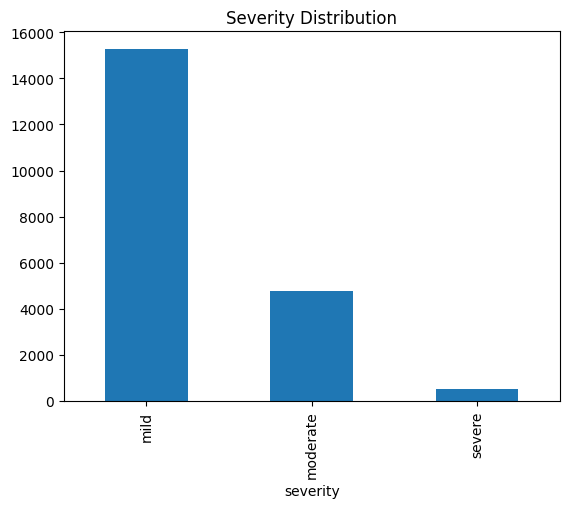

In [ ]:
df['severity'].value_counts().plot(kind='bar', title='Severity Distribution')


<Axes: >

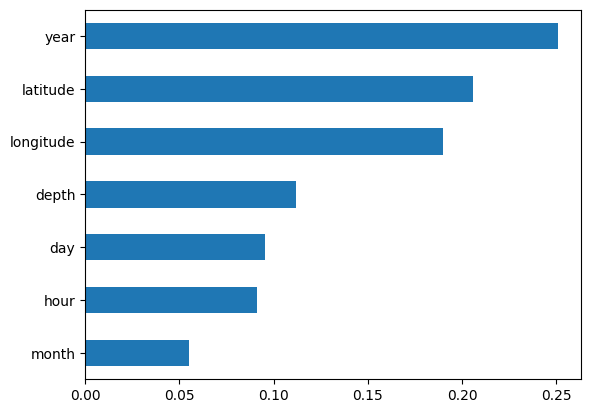

In [ ]:
importances = clf_model.feature_importances_
pd.Series(importances, index=X.columns).sort_values().plot(kind='barh')


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X = full[["latitude", "longitude", "depth"]]
y = full["mag"]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


reg_model = LinearRegression()
reg_model.fit(X_train, y_train)


import joblib
joblib.dump(reg_model, "magnitude_regressor.pkl")


['magnitude_regressor.pkl']

In [ ]:
import joblib
joblib.dump(clf_model, "earthquake_classifier.pkl")
joblib.dump(reg_model, "magnitude_regressor.pkl")


['magnitude_regressor.pkl']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pandas as pd


X = df[features]
y_reg = df['mag']
y_clf = (df['mag'] >= 5).astype(int)

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)


reg = RandomForestRegressor(random_state=42).fit(X_train, y_reg_train)
clf = RandomForestClassifier(random_state=42).fit(X_train, y_clf_train)


reg_preds = reg.predict(X_test)
clf_preds = clf.predict(X_test)


preds_df = pd.DataFrame({
    "Actual_Magnitude":    y_reg_test.values,
    "Predicted_Magnitude": reg_preds,
    "Actual_Severity":     y_clf_test.values,
    "Predicted_Severity":  clf_preds
})


print(preds_df.shape)
preds_df.head()


(4113, 4)


,Actual_Magnitude,Predicted_Magnitude,Actual_Severity,Predicted_Severity
0,2.55,2.8710,0,0
1,4.30,4.1570,0,0
2,2.50,2.9776,0,0
3,2.60,2.8482,0,0
4,3.26,3.1474,0,0


In [ ]:
import joblib
joblib.dump(reg, 'regressor_model.pkl')
joblib.dump(clf, 'classifier_model.pkl')


['classifier_model.pkl']

In [ ]:
import joblib
joblib.dump(reg, 'magnitude_regressor.pkl')
joblib.dump(clf, 'severity_classifier.pkl')


['severity_classifier.pkl']

In [ ]:
preds_df.to_csv('earthquake_model_predictions.csv', index=False)


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib


df = pd.read_csv("earthquake_with_severity.csv")


features = ["latitude", "longitude", "depth"]
X = df[features]
y_reg = df["mag"]
y_clf_raw = df["severity"]


le = LabelEncoder()
y_clf = le.fit_transform(y_clf_raw)


reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X, y_reg)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y_clf)


joblib.dump(reg, "regressor.pkl")
joblib.dump((clf, le), "classifier.pkl")

print(" Models saved: regressor.pkl, classifier.pkl")


 Models saved: regressor.pkl, classifier.pkl


In [ ]:
from google.colab import files
files.download("regressor.pkl")
files.download("classifier.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(df['severity'].value_counts())


severity
mild        15277
moderate     4785
severe        502
Name: count, dtype: int64


In [ ]:
import os
print(os.listdir())


['.config', 'severity_classifier.pkl', 'regressor.pkl', 'earthquake_with_severity.csv', 'requirements.txt', 'classifier_model.pkl', 'earthquake_3000_plus (2).csv', 'earthquake_3000_plus.csv', 'earthquake_model_predictions.csv', 'drive', 'models', 'magnitude_regressor.pkl', 'earthquake_classifier.pkl', 'classifier.pkl', 'regressor_model.pkl', 'sample_data']


In [ ]:
from textblob import TextBlob

def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment < 0:
        return "Negative sentiment detected, earthquake might be imminent."
    elif sentiment > 0:
        return "Positive sentiment detected, no immediate concern."
    else:
        return "Neutral sentiment."


text = "A massive earthquake is expected soon in this region."
print(analyze_sentiment(text))


Negative sentiment detected, earthquake might be imminent.


In [ ]:
from transformers import pipeline

nlp = pipeline('sentiment-analysis')

text = "Urgent: Earthquake warning in the coastal region!"
result = nlp(text)
print(result)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'NEGATIVE', 'score': 0.6475856900215149}]
